In [1]:
#import

import numpy as np
import time
import os, zipfile, shutil,gzip
import pandas as pd
import glob
from scipy.stats import linregress
import requests
import os
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
import math
import scipy
from numpy import polyfit, poly1d
from scipy import interpolate
import matplotlib as mpl
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from sklearn.preprocessing import PolynomialFeatures
from collections import Counter
import collections
import Hawkes as hk
from sklearn.linear_model import LinearRegression 
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import joblib
import akshare as ak
if not sys.warnoptions:
    warnings.simplefilter("ignore")

D:\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\杜威\AppData\Roaming\Python\Python39\site-packages\akshare\__init__.py:2617: UserWarning: 为了支持更多特性，请将 Pandas 升级到 2.1.0 及以上版本！
  warnings.warn(


In [6]:
name_ls = ak.stock_board_industry_name_ths() 

In [19]:
industry_dic = {}
none_ls = []
for name in none_ls:
    try:
        industry_dic[name] = ak.stock_board_industry_index_ths(symbol=name, start_date="20170101", end_date="20240219")
    except:
        none_ls.append(name)
    time.sleep(1)

In [ ]:
with open('data.json', 'w', encoding='utf-8') as f:  
    json.dump(data, f, ensure_ascii=False, indent=4)
with open('data.json', 'r', encoding='utf-8') as f:  
    loaded_data = json.load(f)  

In [2]:
ex = industry_dic['油气开采及服务']

NameError: name 'industry_dic' is not defined

In [177]:
def momentum(x):
    price_ls = x.values
    return price_ls[-1] / price_ls[0] - 1

def sharpe(returns, risk_free_rate=0.00):  
    return np.mean(returns) / np.std(returns) - risk_free_rate  
    
def cal_index(ex, time_part):
    ex.rename(columns = {'日期':'time', '收盘价': 'close'}, inplace = True)
    ex['time'] = ex['time'].astype('datetime64[D]')
    df = ex[['time', 'close']]
    df['return_-1'] = (df['close'].shift(1) / df['close'] - 1).shift(-1)
    
    df['momentum'] = df.set_index('time')['close'].rolling(window=timedelta(days = time_part), min_periods = 15).apply(momentum).reset_index()['close']
    df['sharpe'] = df.set_index('time')['close'].pct_change().rolling(window=timedelta(days = time_part), min_periods = 15).apply(sharpe).reset_index()['close']
    return df[['time', 'momentum', 'sharpe', 'return_-1']].dropna()

In [178]:
df = []
for name in industry_dic.keys():
    dt = cal_index(industry_dic[name], 31)
    dt['name'] = name
    df.append(dt)
df = pd.concat(df)
df = df.sort_values(by = 'time')

In [179]:
def cal_profit(df, top_n = 5):
    df = df.sort_values('sharpe').reset_index(drop = True)
    long_return = df.tail(5)['return_-1'].mean() * -1
    short_return = df.head(5)['return_-1'].mean() 
    return pd.DataFrame({  
        'time': [df['time'].values[0]],
        'long_return': [long_return + 1],  
        'short_return': [short_return + 1],  
        'long&short_return': [long_return + short_return + 1]  
    })
    
df = df.groupby('time', as_index = False).apply(cal_profit)
for col in ['long_return', 'short_return', 'long&short_return']:
    df[col] = df[col].cumprod()

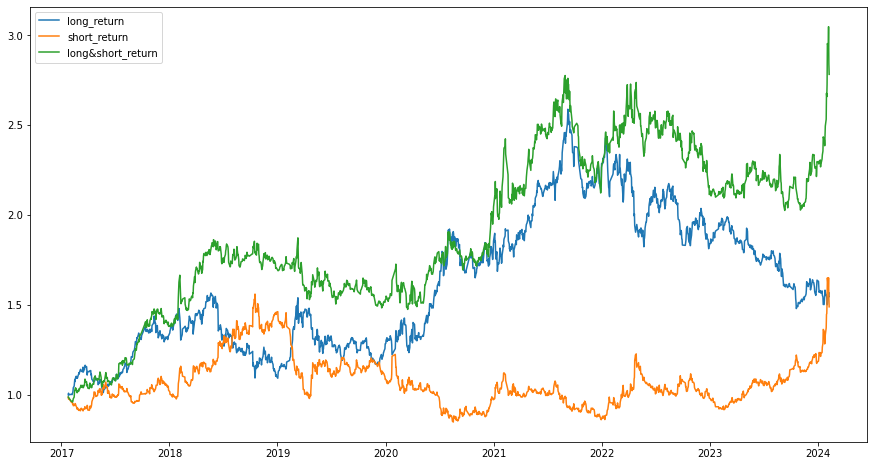

In [180]:
plt.figure(figsize = (15, 8))
for col in ['long_return', 'short_return', 'long&short_return']:
    plt.plot(df.time, df[col], label = col)
plt.legend()